### 2. Entrenamiento de RNNs en una serie de tiempo

En esta sección se trabajará con modelos de redes neuronales recurrentes, es decir una serie de registros (típicamente valores reales) regularmente indexados en el tiempo. Para ello se utilizará el dataset denominado _"international airline passengers"_. En particular la tarea consiste en predecir el número de pasajeros (miles) en vuelos internacionales por medio de diferentes configuraciones recurrentes. Se hará uso de las siguientes librerías:

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import GRU
from keras.layers import SimpleRNN

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import cross_validation

import warnings
warnings.filterwarnings('ignore')

***a)*** Inicialmente se crea la función _cargar_ que, como su nombre lo indica, carga los datos a utilizar, los divide en conjuntos de entrenamiento y test, y los escala. Además, obtiene una representación gráfica del _dataframe_ en cuestión.

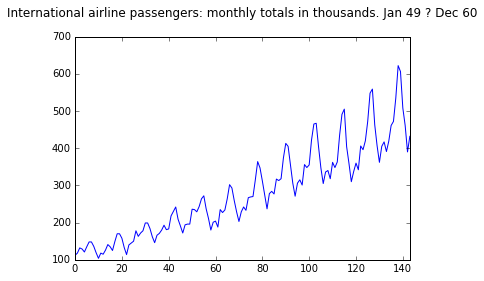

In [1]:
def cargar(file_name):
    dataframe = pandas.read_csv(file_name, sep=',', usecols=[1], engine='python', skipfooter=3)
    dataframe[:] = dataframe[:].astype('float32')
    df_train, df_test = dataframe[0:96].values, dataframe[96:].values
    dataframe.plot(title=dataframe.columns[0]+"\n", legend=False)

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
    stream_train_scaled = scaler.transform(df_train)
    stream_test_scaled = scaler.transform(df_test)
    return scaler, stream_train_scaled, stream_test_scaled

scaler, stream_train_scaled, stream_test_scaled = cargar('international-airline-passengers.csv')

***b)*** Ahora, es conveniente manipular los datos para permitir la predicción de la cantidad de pasajeros para el tiempo siguiente usando la cantidad de pasajeros de los últimos períodos de tiempo. El número de períodos de tiempos a utilizar se denomina lag. Por ejemplo, se considera un lag igual a 3, si para predecir el valor $x_{t+1}$ en el tiempo siguiente se usa la información del tiempo actual $x_t$ y la de los dos períodos anteriores $x_{t−1}$, $x_{t−2}$ como variables de entrada.

Para esto se crea la función *create_dataset* que recibe una secuencia de valores y la transforma en dos arreglos *dataX* (inputs) y *dataY* (targets) donde el número de características de la matriz de entrada (columnas) corresponde al número de períodos de tiempos que se considerarán como información (lag).

In [2]:
def create_dataset(dataset, lag=1):
    dataset = dataset.reshape(len(dataset)) 
    dataY = dataset[lag:] # Creacion Y
    dataX = np.zeros((len(dataY), lag)) 
    for i in range(len(dataY)):
        dataX[i] = dataset[i:lag+i]
    
    return np.array(dataX), np.array(dataY)

Por ejemplo, si en el arreglo _dataset_ tenemos la secuencia 112, 118, 132, 129, 121, 135, 148, la función genera:

In [3]:
dataset = np.array([112, 118, 132, 129, 121, 135, 148])
create_dataset(dataset, 3)

(array([[ 112.,  118.,  132.],
        [ 118.,  132.,  129.],
        [ 132.,  129.,  121.],
        [ 129.,  121.,  135.]]), array([129, 121, 135, 148]))

Donde las tres columnas de la matriz corresponden a $X_1$, $X_2$ y $X_3$ respectivamente, mientras que $Y$ está determinada por el vector $[129,121,135,148]$.

***c)*** Usando la función anterior, se generan los conjuntos de entrenamiento y test para el problema:

In [4]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

***d)*** Hasta aquí, se tienen datos en la forma [ejemplos, atributos]. Sin embargo, la red LSTM necesita que los datos se encuentren en un arreglo de tres dimensiones [samples, time steps, features]. Para esto, se transforma el train y test sets a la estructura deseada:

In [5]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

***e)*** Se procede a entrenar una LSTM (con cuatros bloques) usando un lag de 3. Notar que la funciones de activación corresponden a Tanh y Sigmoidal, esta última empleada para la recurrencia del modelo.

In [6]:
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
model.save('training2/lstm-lag3.h5')

Using Theano backend.
Using gpu device 0: GeForce GT 740M (CNMeM is disabled, cuDNN not available)


Se carga el modelo resultante, y se grafica la evolución de la pérdida en función de las 100 epochs de entrenamiento:

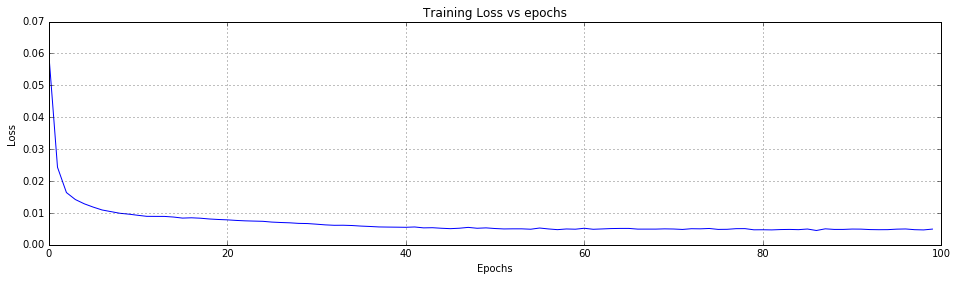

In [8]:
model = load_model('training2/lstm-lag3.h5')
plt.figure(figsize=(16, 4))
plt.plot(hist.epoch, hist.history['loss']) 
plt.title("Training Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

***f)*** Luego, se realizan las predicciones del modelo generado en _e)_, para los conjuntos de entrenamiento y prueba. Notar que se denormalizan los datos para que el error pueda ser computado en la escala original.

In [9]:
#Predicción conjunto de entrenamiento
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

#Predicción conjunto de prueba
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

***g)*** Y se computa el _root mean square error_ (RMSE) sobre los conjuntos de entrenamiento y test:

In [11]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.32 RMSE
Test Score: 66.18 RMSE


Así, se obtiene una medida de disimilitud entre la cantidad de pasajeros en los vuelos predicho por el modelo y aquella cantidad efectivamente verificada. Al observar la amplia diferencia entre errores obtenidos para el conjunto de entrenamiento (21.32 de RMSE) y de prueba (66.18 de RMSE), se comprueba experimentalmente la presencia de _overfitting_ durante el entrenamiento.

***h)*** A continuación, se crea la función _graficar_, la cual, como su nombre lo indica, grafica las predicciones del train y test set, y las contrasta con la serie de tiempo original:

In [12]:
def graficar(lag, original_data, trainPredict, testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataframe.values)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataframe.values)
    testPredictPlot[:, :] = np.nan

    testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.xlabel("Sample")
    plt.ylabel("Passenger number")
    plt.legend(loc='upper left')
    plt.title("International Airline Passengers")
    plt.plot(trainPredictPlot, 'b-x', label="Train predict")
    plt.plot(testPredictPlot, 'r-x', label="Test predict")
    plt.plot(original_data, '-k', label="Original data")

    plt.show()

Se hace uso de la función, utilizando un lag igual a 3:

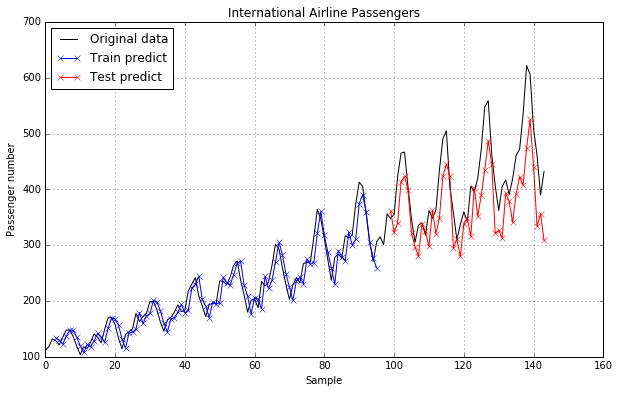

In [13]:
graficar(3, dataframe, trainPredict, testPredict)

El gráfico permite certificar visualmente el momento en que ambas predicciones de entrenamiento y de test comienzan a ser efectivas, tiempo que esta completamente determinado por el lag utilizado. Además, se demuestra cualitativamente el efecto del _overfitting_ mencionado en la sección anterior, esto evidenciado por las muy buenas predicciones generadas por el conjunto de entrenamiento, en contraposición de las deficientes predicciones realizadas sobre el conjunto de pruebas, aunque incluso este último es capaz de recuperar a grandes rasgos las fluctuaciones de las secuencias observadas en la data original.

***h')*** Ahora, se determina el número de bloques LSTM usando 5-fold Cross Validation que permite optimizar el error de entrenamiento. Para llevar a cabo esta tarea, se experimenta con 4, 6, 8, 10 y 12 bloques:

In [14]:
nb = range(4,13,2)
lag = 3

trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

kfold = cross_validation.KFold(len(trainX), len(nb))
mse_cv = np.zeros(len(nb))

for j in range(len(nb)):
    cvscores = np.zeros(len(kfold))
    for i, (train, val) in enumerate(kfold):
        model = Sequential()
        model.add(LSTM(output_dim=nb[j], input_dim=lag, activation='tanh', inner_activation='sigmoid'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        hist = model.fit(trainX[train], trainY[train], nb_epoch=100, batch_size=1, verbose=0)
        trainPredict = model.predict(trainX[val])
        trainPredict = scaler.inverse_transform(trainPredict)
        trainYP = scaler.inverse_transform([trainY[val]])
        cvscores[i] = math.sqrt(mean_squared_error(trainYP[0], trainPredict[:,0]))      
    mse_cv[j] = cvscores.mean()
    print("RMSE para %d bloques: %.4f" % (nb[j], mse_cv[j]))

RMSE para 4 bloques: 24.5630
RMSE para 6 bloques: 24.7523
RMSE para 8 bloques: 23.1751
RMSE para 10 bloques: 21.8791
RMSE para 12 bloques: 23.3954


Para mayor comprensión, se grafica los RMSE para sus respectivas cantidades de bloques utilizados:

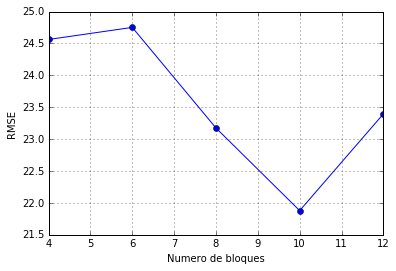

In [15]:
plt.plot(nb, mse_cv, 'b-o')
plt.grid(True)
plt.xlabel("Numero de bloques")
plt.ylabel("RMSE")
plt.show()

Si bien no es posible deducir un comportamiento evidente del RMSE en función del número de bloques LSTM, el experimento permite determinar que el RMSE es menor cuando se utilizan 10 bloques (21.8791 RMSE), superando el error encontrado en g) por medio del empleo de 4 bloques LSTM. Además se observa bastante poca variación en el error entre experimentos, encontrando RMSE's particularmente similares para los casos en que el número de bloques utilizados es distinto del óptimo encontrado (10 bloques).

***i)*** Se procede a evaluar el efecto sobre el desempeño de la red LSTM al variar el lag en un intervalor $[1,4]$, manteniendo por razones comparativas la cantidad de bloques LSTM en cuatro:

In [17]:
def variar_lag(lag, blocks=4, batch_size=1):
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    model = Sequential()
    model.add(LSTM(blocks, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    hist = model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)
    trainPredict = model.predict(trainX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    return trainPredict, trainY, testPredict, testY, hist

lag = np.arange(1, 5)

trainsPredicted = [None]*4
trainsY = [None]*4 
testsPredicted = [None]*4
testsY = [None]*4
hist = [None]*4
scoreTrain = np.zeros(4)
scoreTest = np.zeros(4)

def RMSE(real, predict):
    return math.sqrt(mean_squared_error(real, predict))

for i in range(4):

    trainsPredicted[i], trainsY[i], testsPredicted[i], testsY[i], hist = variar_lag(lag[i])
    
    # RMSE
    scoreTrain[i] = RMSE(trainsY[i][0], trainsPredicted[i][:,0])
    scoreTest[i] = RMSE(testsY[i][0], testsPredicted[i][:,0])

    print("Training RMSE para lag=%d: %.4f" % (lag[i], scoreTrain[i]))
    print("Testing RMSE para lag=%d: %.4f" % (lag[i], scoreTest[i]))

Training RMSE para lag=1: 22.7700
Testing RMSE para lag=1: 60.3905
Training RMSE para lag=2: 21.6179
Testing RMSE para lag=2: 63.2812
Training RMSE para lag=3: 21.7824
Testing RMSE para lag=3: 74.6476
Training RMSE para lag=4: 21.3622
Testing RMSE para lag=4: 64.7271


Para mayor comprensión, análogamente a lo realizado en _h)_, se grafican las predicciones del train y test set, y se contrastan con la serie de tiempo original, para cada uno de los valores de lag experimentados:

Para lag=1


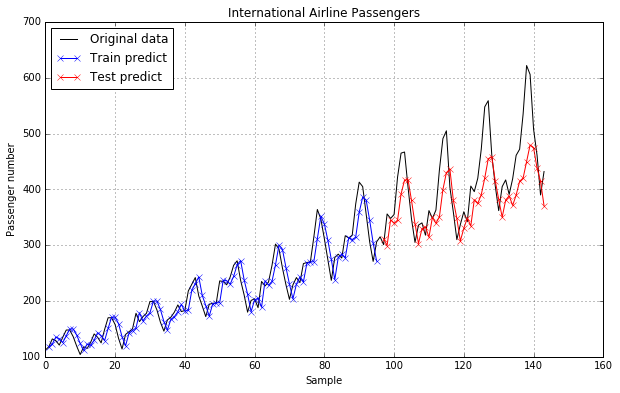

Para lag=2


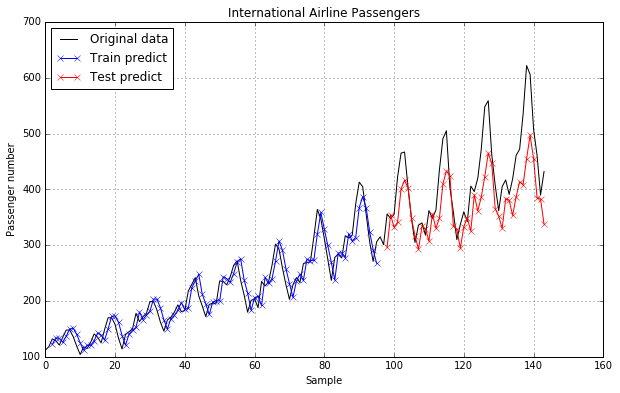

Para lag=3


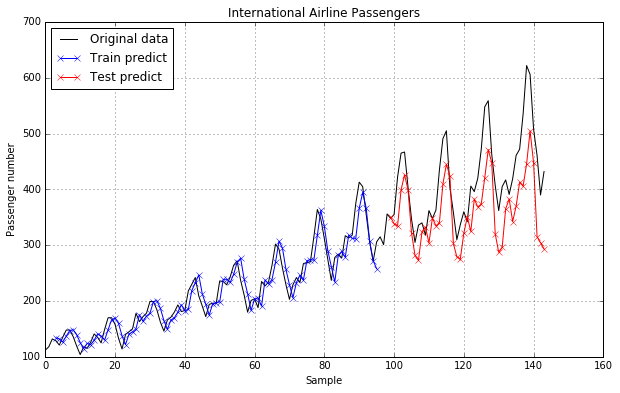

Para lag=4


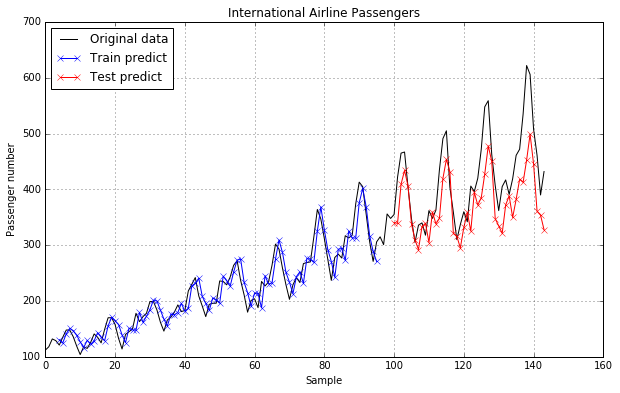

In [19]:
for l in range(len(lag)):
    print("Para lag=%d"%(lag[l]))
    graficar(lag[l], dataframe, trainsPredicted[l], testsPredicted[l])

En términos generales, no existen grandes variaciones con los resultados obtenidos en_ h)_ para el error de predicción de entrenamiento, sin embargo, se observan variaciones ligeramente mayores al analizar el error de predicción sobre el conjunto de pruebas RMSE al variar el lag utilizado. En particular lag igual a 1 arrojó el menor RMSE (60.3905), que si bien tiende a subvalorar la cantidad de pasajeros (revisar gráfico respectivo), es aquel que permite un mejor ajustamiento de la data original. Aunque la diferencia de RMSE de entrenamiento y prueba siguen siendo muy grandes, el uso de lag igual a 1 reduce levemente el _overfitting_ observado, mientras que lag igual a 3 incurre incluso en un mayor sobreajustamiento de los datos.

***j)*** Usando un lag de 3 (peor desempeño observado en la sección anterior) y cantidad de bloques LSTM igual a 4, se compara el desempeño de la LSTM con una red recurrente simple y una GRU:

In [32]:
def recurrencia(lag, rnn):
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    model = Sequential() 
    if rnn == 'GRU':
        model.add(GRU(input_dim=trainX.shape[2], output_dim=4, inner_init='orthogonal', activation='tanh'))
    elif rnn == 'RNN':
        model.add(SimpleRNN(input_dim=trainX.shape[2], output_dim=4, inner_init='orthogonal',activation='tanh'))        
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    hist = model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)
    trainPredict = model.predict(trainX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    return trainPredict, trainY, testPredict, testY, hist

lag = 3
GRUtrainPredict, GRUtrainY, GRUtestPredict, GRUtestY, GRUhist = recurrencia(lag, 'GRU')
RNNtrainPredict, RNNtrainY, RNNtestPredict, RNNtestY, RNNhist = recurrencia(lag, 'RNN')

Para calcular el desempeño de una GRU:

In [28]:
GRUscoreTrain = RMSE(GRUtrainY[0], GRUtrainPredict[:,0])
GRUscoreTest = RMSE(GRUtestY[0], GRUtestPredict[:,0])

print("Training RMSE para GRU: %.4f" % (GRUscoreTrain))
print("Testing RMSE para GRU: %.4f" % (GRUscoreTest))

Training RMSE para GRU: 24.2970
Testing RMSE para GRU: 51.9611


Y graficando sus respectivos RMSE's predictivos:

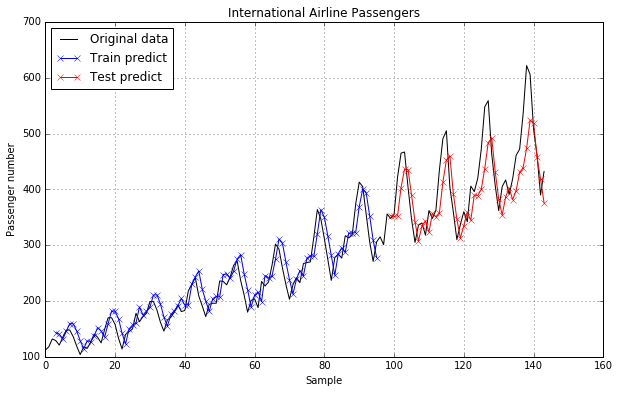

In [31]:
graficar(3, dataframe, GRUtrainPredict, GRUtestPredict)

Para calcular el desempeño de una red recurrente simple:

In [29]:
# RMSE RNN
RNNscoreTrain = RMSE(RNNtrainY[0], RNNtrainPredict[:,0])
RNNscoreTest = RMSE(RNNtestY[0], RNNtestPredict[:,0])

print("Training RMSE para RNN: %.4f" % (RNNscoreTrain))
print("Testing RMSE para RNN: %.4f" % (RNNscoreTest))

Training RMSE para RNN: 21.5952
Testing RMSE para RNN: 67.3614


Y graficando sus respectivos RMSE's predictivos:

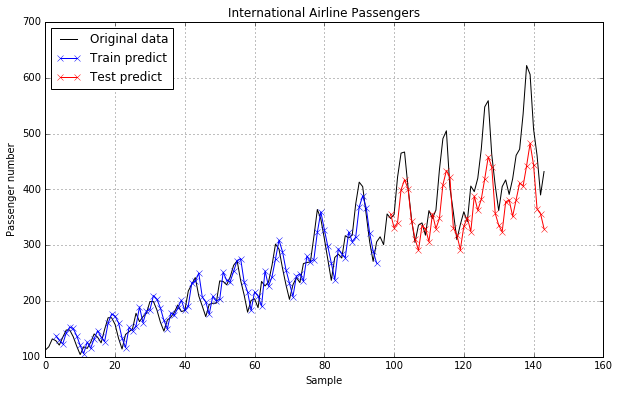

In [30]:
graficar(3, dataframe, RNNtrainPredict, RNNtestPredict)

Los resultados arrojados por la RNN parecen ser ligeramente superiores a los obtenidos por la LSTM. Sin embargo, la GRU consigue considerables mejoras en su error de predicción sobre el conjunto de pruebas, econtrando el menor RMSE observado hasta este momento de la experimentación (RMSE igual a 51.9611). La disminusión del _overfitting_ es evidenciado gráficamente con un notorio ajustamiento de la curva con respecto a la data original. 

Además, se observa en la experimentación que los modelos GRU y RNN disminuyen considerablemente el tiempo de entrenamiento y y de predicción con respecto a los previamente obtenidos por arquitecturas LSTM.

***k)*** Hasta aquí se a trabajado casi invariablemente con entradas de dimensionalidad 3 (_lag = 3_), para predecir la cantidad de pasajeros en una única iteración recurrente (_timestep = 1_). A continuación se modifican dicho parámetros a _lag = 1_ y _timestep = 3 _:

In [33]:
trainPredict1, trainY1, testPredict1, testY1, hist1 = LSTM_experiment(lag=1)
scoreTrain1 = RMSE(trainY1[0], trainPredict1[:,0])
scoreTest1 = RMSE(testY1[0], testPredict1[:,0])

print("Training RMSE para LSTM lag=1: %.4f" % (scoreTrain1))
print("Testing RMSE para LSTM lag=1: %.4f" % (scoreTest1))

Training RMSE para LSTM lag=1: 22.7269
Testing RMSE para LSTM lag=1: 60.0606


Y graficando para mayor comprensión:

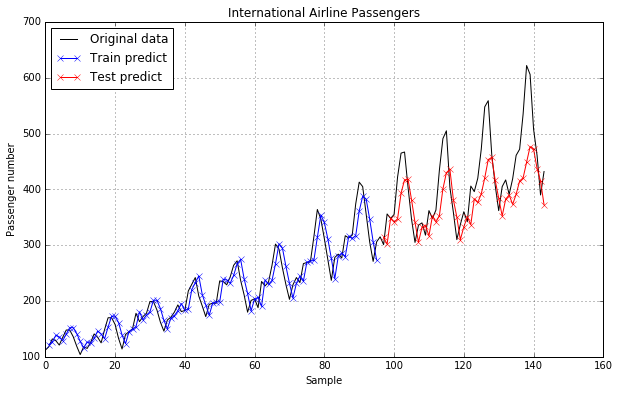

In [34]:
graficar(1, dataframe, trainPredict1, testPredict1)

Esta experimentación arroja resultados correspondientes a los RMSE's asociados muy similares a secciones anterior. La gran diferencia radica en la sustancial reducción de los tiempos de computación producto de una fuerte disminusión en el número de
períodos de tiempos previos utilizados para la predicción.

***k')*** Luego, se entrena la red LSTM con memoria entre batches, con un tamaño de batch igual a 1. Cabe destacar ques esta medida permite la conservación del estado del modelo durante el procesamiento de los respectivos batches. Nuevamente por efectos comparativos se entrena la red con la configuración _lag = 3_ y cantidad de bloques LSTM igual a cuatro.

In [37]:
def lstm_memoria(lag=3, blocks=4, batch_size=1):

    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
        
    model = Sequential()
    model.add(LSTM(blocks, batch_input_shape=(batch_size, lag, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    hist = []
    
    for i in range(100):
        hist.append(model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False))
        model.reset_states()

    trainPredict = model.predict(trainX, batch_size=batch_size)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = model.predict(testX, batch_size=batch_size)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    return trainPredict, trainY, testPredict, testY, hist

trainPredictMem, trainYMem, testPredictMem, testYMem, histMem = lstm_memoria()

scoreTrainMem = RMSE(trainYMem[0], trainPredictMem[:,0])
scoreTestMem = RMSE(testYMem[0], testPredictMem[:,0])

print("Training RMSE para LSTM con memoria entre batches: %.4f" % (scoreTrainMem))
print("Testing RMSE para LSTM con memoria entre batches:: %.4f" % (scoreTestMem))

Training RMSE para LSTM con memoria entre batches: 20.4783
Testing RMSE para LSTM con memoria entre batches:: 57.4414


Graficando los resultados:

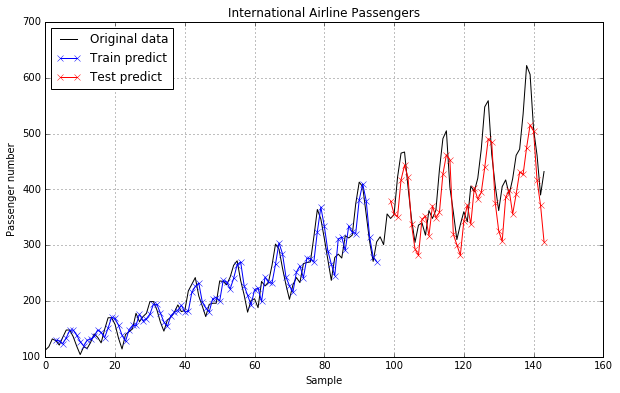

In [38]:
graficar(3, dataframe, trainPredictMem, testPredictMem)

Los resultados obtenidos son superados por aquellos encontrados en en secciones anteriores. Aquí, se mantiene un tiempo computacional relativamente mayor al conseguido en _k)_ (lo cual nuevamente podría ser reducido al decrecer el lag), mientras que el error de predicción sobre el conjunto de pruebas es considerablemente mayor que aquel obtenido en _j)_. Así, esta estrategia resulta en un nivel intermedio de competitividad con respecto al resto de experimentaciones realizadas.

***l)*** Se repite el procedimiento anterior variando el tamaño de batch a 3:

In [40]:
trainPredictMem3, trainYMem3, testPredictMem3, testYMem3, histMem3 = lstm_memoria(batch_size=3)
scoreTrainMem3 = RMSE(trainYMem3[0], trainPredictMem3[:,0])
scoreTestMem3 = RMSE(testYMem3[0], testPredictMem3[:,0])

print("Training RMSE para LSTM con memoria entre batches: %.4f" % (scoreTrainMem3))
print("Testing RMSE para LSTM con memoria entre batches: %.4f" % (scoreTestMem3))

Training RMSE para LSTM con memoria entre batches: 26.5327
Testing RMSE para LSTM con memoria entre batches: 70.4133


Graficando los resultados:

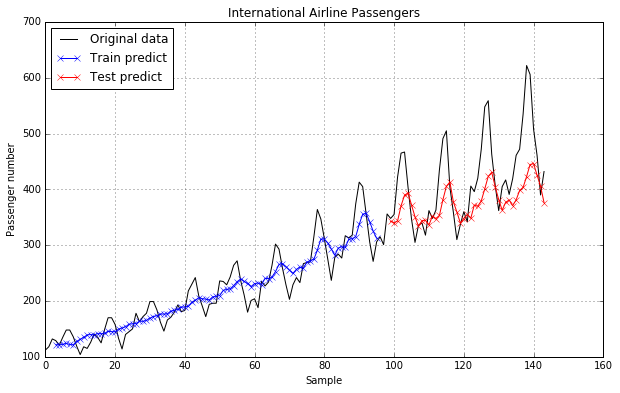

In [41]:
graficar(3, dataframe, trainPredictMem3, testPredictMem3)

Lamentablemente el incrementar el tamaño de batches no arroja el resultado esperado. A partir del gráfico se reflejan errores de predicción bastante más altos de los encontrados con los mejores modelos usados hasta aquí. Resulta interesante el particular decremento de calidad de la predicción sobre el conjunto de entrenamiento, lo cual sugiere un seteo de parámetros deficiente que hiere el modelamiento de secuencias de la LSTM.

***m)*** Finalmente se construye una LSTM apilada, con el fin de analizar la conveniencia de usar profundidad en un contexto de recurrencia. Se utiliza la misma configuración de la sección anterior, esto con la intención de mejorar su rendimiento e incluir tal esquema como una alternativa para resolver el problema predictivo de la cantidad de pasajeros en vuelos internacionales. 

In [44]:
def lstm_profundo(lag=3, blocks=4, batch_size=3):
    # Normalizar datos
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)

    # Formatear datos
    # Datos de entrenamiento
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    # Datos de prueba
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
        
    # Creacion de modelo
    model = Sequential()
    model.add(LSTM(blocks, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
    model.add(LSTM(blocks, batch_input_shape=(batch_size, lag, 1), stateful=True))
    model.add(Dense(1))
    
    # Compilar modelo
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    hist = []

    # Ajustar modelo (memoria)
    for i in range(100):
        hist.append(model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False))
        model.reset_states()

    # Evaluar modelo
    # Prediccion de entrenamiento
    trainPredict = model.predict(trainX, batch_size=batch_size)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    
    # Prediccion de prueba
    testPredict = model.predict(testX, batch_size=batch_size)

    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    return trainPredict, trainY, testPredict, testY, hist

trainPredictMemS, trainYMemS, testPredictMemS, testYMemS, histMemS = lstm_profundo()
scoreTrainMemS = RMSE(trainYMemS[0], trainPredictMemS[:,0])
scoreTestMemS = RMSE(testYMemS[0], testPredictMemS[:,0])

print("Training RMSE para LSTM con memoria entre batches: %.4f" % (scoreTrainMemS))
print("Testing RMSE para LSTM con memoria entre batches:: %.4f" % (scoreTestMemS))

Training RMSE para LSTM con memoria entre batches: 29.7601
Testing RMSE para LSTM con memoria entre batches:: 85.7662


Graficando los resultados:

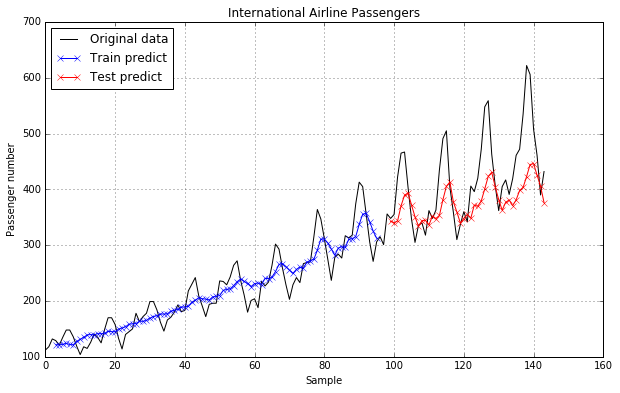

In [45]:
graficar(3, dataframe, trainPredictMem3, testPredictMem3)

Así, se demuestra experimentalmente la ineficacia de la profundidad para esta tarea predictiva. Los errores de predicción, tanto para el conjunto de entrenamiento como el de prueba, corresponde a los más altos obtenidos a lo largo de toda la actividad (incluso mayores a los obtenidos en _l)_), encontrando RMSE's de 29.7601 y 85.7662 respectivamente, y evidenciando un alto _overfitting_ producido en gran medida por un particular mal rendimiento sobre el conjunto de pruebas. La figura corrobora dichas conclusiones. Por último, se destaca negativamente el considerable aumento del tiempo computacional invertido, lo cual es un resultado esperado en escenarios de modelos profundos. 